<a href="https://colab.research.google.com/github/washwin/RamSpec_Bacterial_Classification/blob/main/neural_networks_tree_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Step 1: Load Data ---
# Replace with your actual data loading
# Example placeholder: Replace with your DataFrame
# df = pd.read_csv('/content/drive/MyDrive/preprocessed_ds.csv')
df = pd.read_csv('/content/drive/MyDrive/preprocessed_ds used.csv')

# Features and labels
X = df.drop(columns=['label', 'Class'])
y = df['label']  # Target variable (bacterial strain 9 total, 100 per label)

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# --- Step 2: Train Decision Tree (or Random Forest) ---
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Extract feature importances and pseudo-labels
important_features = rf_clf.feature_importances_
rf_train_probs = rf_clf.predict_proba(X_train)  # Probabilities as additional features
rf_test_probs = rf_clf.predict_proba(X_test)

# Augment original features with probabilities
X_train_augmented = np.hstack([X_train, rf_train_probs])  # Combine original features and tree probabilities
X_test_augmented = np.hstack([X_test, rf_test_probs])

In [ ]:
# --- Step 3: Build Neural Network ---
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_augmented.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# --- Step 4: Train the Hybrid Model ---
history = model.fit(
    X_train_augmented, tf.keras.utils.to_categorical(y_train, num_classes=len(le.classes_)),
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.1750 - loss: 2.1339 - val_accuracy: 0.4236 - val_loss: 2.0351 - learning_rate: 0.0010
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3551 - loss: 2.0573 - val_accuracy: 0.4583 - val_loss: 1.8538 - learning_rate: 0.0010
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5290 - loss: 1.8423 - val_accuracy: 0.8542 - val_loss: 1.6245 - learning_rate: 0.0010
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6397 - loss: 1.6592 - val_accuracy: 0.9167 - val_loss: 1.3422 - learning_rate: 0.0010
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7702 - loss: 1.3834 - val_accuracy: 0.9583 - val_loss: 0.9795 - learning_rate: 0.0010
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8509 - loss: 1.0292 - val_accuracy: 0.9792 - val_loss: 0.7123 - learning_rate: 0.0010
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9170 - loss: 0.7944 - val_a

In [ ]:
# --- Step 5: Evaluate the Hybrid Model ---
y_pred_proba = model.predict(X_test_augmented)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Classification Report:
                         precision    recall  f1-score   support

Enterobacter_aerogenes       0.78      0.72      0.75        25
 Enterococcus_faecalis       0.64      0.64      0.64        14
       Eschericia_coli       0.92      0.71      0.80        17
      Listeria_innocua       0.85      0.81      0.83        27
Listeria_monocytogenes       0.76      0.72      0.74        18
     Rhodococcus_equii       0.70      0.88      0.78        16
               S_abony       0.82      0.75      0.78        24
        Shigella_boydi       0.91      0.95      0.93        22
 Staphylococcus_aureus       0.71      0.94      0.81        16

              accuracy                           0.79       179
             macro avg       0.79      0.79      0.79       179
          weighted avg       0.80      0.79      0.79       179



In [ ]:
# --- Step 6: Visualize Results ---
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def advanced_feature_selection(X, y, n_features=100):
    # Combine multiple feature selection techniques

    # Mutual Information Feature Selection
    selector_mi = SelectKBest(score_func=mutual_info_classif, k=n_features)
    X_mi = selector_mi.fit_transform(X, y)
    mi_features = selector_mi.get_support(indices=True)

    # PCA for dimensionality reduction
    pca = PCA(n_components=0.95)  # Retain 95% variance
    X_pca = pca.fit_transform(X)

    # Random Forest Feature Importance
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X, y)
    rf_importance = rf.feature_importances_
    top_rf_features = np.argsort(rf_importance)[-n_features:]

    # Combine feature sets
    combined_features = list(set(mi_features) | set(top_rf_features))

    return X[:, combined_features], combined_features

def create_hybrid_model(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,),
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def robust_training_pipeline(X, y):
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Performance tracking
    cv_scores = []

    # Full results storage
    all_predictions = []
    all_true_labels = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold}")

        # Split data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Encode labels using LabelEncoder
        le = LabelEncoder()
        y_train = le.fit_transform(y_train) # Encode y_train
        y_val = le.transform(y_val)       # Encode y_val using the same encoder


        # Feature Selection
        X_train_selected, selected_features = advanced_feature_selection(X_train, y_train)
        X_val_selected = X_val[:, selected_features]

        # Neural Network Model
        model = create_hybrid_model(
            input_shape=X_train_selected.shape[1],
            num_classes=len(np.unique(y))
        )

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-5
        )

        # Training
        history = model.fit(
            X_train_selected, y_train,
            validation_data=(X_val_selected, y_val),
            epochs=200,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Predictions
        y_pred = model.predict(X_val_selected)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Store results
        all_predictions.extend(y_pred_classes)
        all_true_labels.extend(y_val)

        # Evaluate this fold
        fold_report = classification_report(y_val, y_pred_classes)
        print(f"Fold {fold} Classification Report:")
        print(fold_report)

    # Final overall report
    print("\nOverall Cross-Validation Results:")
    print(classification_report(all_true_labels, all_predictions))

# Example usage (replace with your actual data loading)
# df = pd.read_csv('your_dataset.csv')


In [ ]:
# Example Usage (Replace with your actual data loading)
df = pd.read_csv('/content/drive/MyDrive/preprocessed_ds.csv')
X = df.drop(columns=['label']).values
# X = df.drop(columns=['label', 'Class']).values
y = df['label'].values
robust_training_pipeline(X, y)


Fold 1
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - accuracy: 0.1459 - loss: 3.0724 - val_accuracy: 0.2186 - val_loss: 2.5751 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2423 - loss: 2.6590 - val_accuracy: 0.2131 - val_loss: 2.5382 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2939 - loss: 2.3936 - val_accuracy: 0.1803 - val_loss: 2.5131 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3030 - loss: 2.3307 - val_accuracy: 0.2022 - val_loss: 2.5087 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3020 - loss: 2.3020 - val_accuracy: 0.1858 - val_loss: 2.4884 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4063 - loss: 2.1536 - val_accuracy: 0.2459 - val_loss: 2.4550 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4090 - loss: 1.9988 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.1581 - loss: 3.1014 - val_accuracy: 0.1639 - val_loss: 2.5851 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2508 - loss: 2.6488 - val_accuracy: 0.2131 - val_loss: 2.5543 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2620 - loss: 2.5096 - val_accuracy: 0.1366 - val_loss: 2.5243 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2936 - loss: 2.3742 - val_accuracy: 0.1202 - val_loss: 2.5162 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2855 - loss: 2.3048 - val_accuracy: 0.1202 - val_loss: 2.4985 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4045 - loss: 2.0927 - val_accuracy: 0.1257 - val_loss: 2.4775 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4363 - loss: 2.0037 - val_accuracy:

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.95      1.00      0.98        20
           2       0.93      0.88      0.90        16
           3       1.00      0.86      0.93        22
           4       0.91      1.00      0.95        20
           5       0.95      0.95      0.95        20
           6       0.95      0.95      0.95        21
           7       0.86      0.90      0.88        21
           8       0.95      0.95      0.95        21

    accuracy                           0.95       183
   macro avg       0.95      0.94      0.94       183
weighted avg       0.95      0.95      0.95       183


Fold 3
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 262ms/step - accuracy: 0.1600 - loss: 3.1633 - val_accuracy: 0.1154 - val_loss: 2.5882 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2488 - loss: 2.6111 - val_accuracy: 0.1319 - val_loss: 2.5555 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2612 - loss: 2.5295 - val_accuracy: 0.1593 - val_loss: 2.5281 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3387 - loss: 2.3064 - val_accuracy: 0.1593 - val_loss: 2.5139 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3464 - loss: 2.2532 - val_accuracy: 0.1429 - val_loss: 2.5157 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3944 - loss: 2.1520 - val_accuracy: 0.1538 - val_loss: 2.5026 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3601 - loss: 2.1730 - val_accuracy: 0.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.94      0.76      0.84        21
           2       1.00      1.00      1.00        16
           3       0.95      0.95      0.95        21
           4       0.63      0.85      0.72        20
           5       0.79      0.95      0.86        20
           6       1.00      0.85      0.92        20
           7       0.95      0.91      0.93        22
           8       0.95      0.86      0.90        21

    accuracy                           0.90       182
   macro avg       0.91      0.90      0.90       182
weighted avg       0.91      0.90      0.90       182


Fold 4
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 266ms/step - accuracy: 0.1277 - loss: 3.1348 - val_accuracy: 0.1703 - val_loss: 2.5844 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2395 - loss: 2.7547 - val_accuracy: 0.2088 - val_loss: 2.5347 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3079 - loss: 2.3969 - val_accuracy: 0.2363 - val_loss: 2.4896 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3126 - loss: 2.2898 - val_accuracy: 0.1703 - val_loss: 2.4641 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3676 - loss: 2.1261 - val_accuracy: 0.1429 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4131 - loss: 2.0269 - val_accuracy: 0.1758 - val_loss: 2.4328 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4338 - loss: 1.9173 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.1226 - loss: 3.2768 - val_accuracy: 0.1703 - val_loss: 2.5701 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2416 - loss: 2.7173 - val_accuracy: 0.1374 - val_loss: 2.5461 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2426 - loss: 2.5196 - val_accuracy: 0.1648 - val_loss: 2.5366 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3227 - loss: 2.4009 - val_accuracy: 0.1703 - val_loss: 2.5246 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3260 - loss: 2.2426 - val_accuracy: 0.1538 - val_loss: 2.5329 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3689 - loss: 2.1104 - val_accuracy: 0.1758 - val_loss: 2.5215 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3987 - loss: 2.0555 - val_accuracy: 0.


Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.1200 - loss: 3.2615 - val_accuracy: 0.1620 - val_loss: 2.5834 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2366 - loss: 2.6533 - val_accuracy: 0.1453 - val_loss: 2.5468 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2403 - loss: 2.5593 - val_accuracy: 0.1341 - val_loss: 2.5313 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3084 - loss: 2.3630 - val_accuracy: 0.1453 - val_loss: 2.5164 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3251 - loss: 2.2972 - val_accuracy: 0.1173 - val_loss: 2.5033 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3665 - loss: 2.1086 - val_accuracy: 0.1285 - val_loss: 2.4898 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3583 - loss: 2.0875 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.1465 - loss: 3.1768 - val_accuracy: 0.1955 - val_loss: 2.5794 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2251 - loss: 2.7745 - val_accuracy: 0.1676 - val_loss: 2.5489 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2699 - loss: 2.5857 - val_accuracy: 0.1732 - val_loss: 2.5348 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2878 - loss: 2.3475 - val_accuracy: 0.1844 - val_loss: 2.5133 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3335 - loss: 2.3064 - val_accuracy: 0.1955 - val_loss: 2.4943 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3365 - loss: 2.1439 - val_accuracy: 0.1620 - val_loss: 2.4746 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3858 - loss: 2.0752 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.1681 - loss: 3.0833 - val_accuracy: 0.1732 - val_loss: 2.5711 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2136 - loss: 2.7122 - val_accuracy: 0.1676 - val_loss: 2.5347 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2390 - loss: 2.5614 - val_accuracy: 0.1844 - val_loss: 2.5121 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2949 - loss: 2.3582 - val_accuracy: 0.1564 - val_loss: 2.5011 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3083 - loss: 2.3514 - val_accuracy: 0.2011 - val_loss: 2.4661 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3067 - loss: 2.2484 - val_accuracy: 0.1564 - val_loss: 2.4579 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3345 - loss: 2.2762 - val_accuracy: 0.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.95      0.90      0.92        20
           2       0.89      1.00      0.94        16
           3       0.95      0.90      0.92        20
           4       0.76      0.80      0.78        20
           5       0.79      1.00      0.88        19
           6       0.90      0.95      0.93        20
           7       0.94      0.77      0.85        22
           8       1.00      0.86      0.92        21

    accuracy                           0.90       179
   macro avg       0.90      0.90      0.90       179
weighted avg       0.91      0.90      0.90       179


Fold 4
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.1615 - loss: 3.1689 - val_accuracy: 0.1453 - val_loss: 2.5860 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2342 - loss: 2.6715 - val_accuracy: 0.1564 - val_loss: 2.5420 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2683 - loss: 2.4917 - val_accuracy: 0.1397 - val_loss: 2.5220 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2986 - loss: 2.4303 - val_accuracy: 0.1117 - val_loss: 2.5060 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2994 - loss: 2.2737 - val_accuracy: 0.1117 - val_loss: 2.4966 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3784 - loss: 2.1110 - val_accuracy: 0.1117 - val_loss: 2.5012 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3916 - loss: 2.0595 - val_accuracy: 0.1

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        21
           1       1.00      0.90      0.95        20
           2       0.94      1.00      0.97        16
           3       0.95      0.95      0.95        20
           4       0.78      0.90      0.84        20
           5       0.94      0.89      0.92        19
           6       0.86      0.90      0.88        20
           7       0.89      0.81      0.85        21
           8       1.00      0.95      0.98        22

    accuracy                           0.91       179
   macro avg       0.91      0.91      0.91       179
weighted avg       0.91      0.91      0.91       179


Fold 5
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.1473 - loss: 3.2888 - val_accuracy: 0.1285 - val_loss: 2.5785 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2081 - loss: 2.7878 - val_accuracy: 0.1788 - val_loss: 2.5379 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2901 - loss: 2.4472 - val_accuracy: 0.1732 - val_loss: 2.5067 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3232 - loss: 2.3422 - val_accuracy: 0.1732 - val_loss: 2.4874 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3166 - loss: 2.2488 - val_accuracy: 0.1732 - val_loss: 2.4551 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3621 - loss: 2.1553 - val_accuracy: 0.1732 - val_loss: 2.4602 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3583 - loss: 2.0740 - val_accuracy: 0.

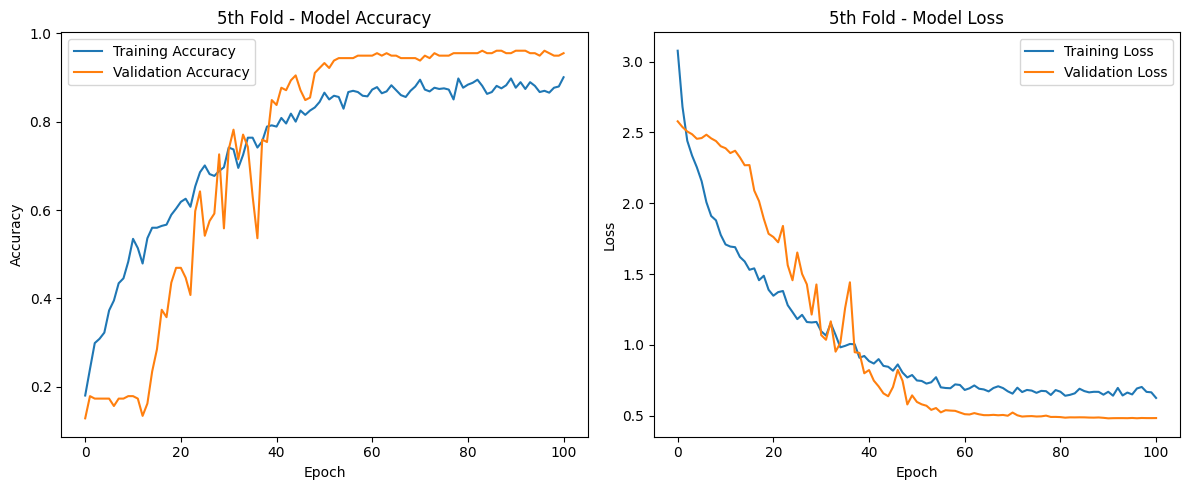


Best Model at Epoch 91:
Best Validation Accuracy: 0.9609
Best Validation Loss: 0.4821
Corresponding Training Accuracy: 0.8771
Corresponding Training Loss: 0.6697


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

def advanced_feature_selection(X, y, n_features=100):
    # Combine multiple feature selection techniques

    # Mutual Information Feature Selection
    selector_mi = SelectKBest(score_func=mutual_info_classif, k=n_features)
    X_mi = selector_mi.fit_transform(X, y)
    mi_features = selector_mi.get_support(indices=True)

    # PCA for dimensionality reduction
    pca = PCA(n_components=0.95)  # Retain 95% variance
    X_pca = pca.fit_transform(X)

    # Random Forest Feature Importance
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X, y)
    rf_importance = rf.feature_importances_
    top_rf_features = np.argsort(rf_importance)[-n_features:]

    # Combine feature sets
    combined_features = list(set(mi_features) | set(top_rf_features))

    return X[:, combined_features], combined_features

def create_hybrid_model(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,),
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def robust_training_pipeline(X, y):
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Performance tracking
    cv_scores = []
    fold_histories = []

    # Full results storage
    all_predictions = []
    all_true_labels = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold}")

        # Split data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Encode labels using LabelEncoder
        le = LabelEncoder()
        y_train = le.fit_transform(y_train) # Encode y_train
        y_val = le.transform(y_val)       # Encode y_val using the same encoder

        # Feature Selection
        X_train_selected, selected_features = advanced_feature_selection(X_train, y_train)
        X_val_selected = X_val[:, selected_features]

        # Neural Network Model
        model = create_hybrid_model(
            input_shape=X_train_selected.shape[1],
            num_classes=len(np.unique(y))
        )

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-5
        )

        # Training
        history = model.fit(
            X_train_selected, y_train,
            validation_data=(X_val_selected, y_val),
            epochs=200,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Store training history for this fold
        fold_histories.append({
            'fold': fold,
            'history': history.history
        })

        # Predictions
        y_pred = model.predict(X_val_selected)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Store results
        all_predictions.extend(y_pred_classes)
        all_true_labels.extend(y_val)

        # Evaluate this fold
        fold_report = classification_report(y_val, y_pred_classes)
        print(f"Fold {fold} Classification Report:")
        print(fold_report)

    # Final overall report
    print("\nOverall Cross-Validation Results:")
    print(classification_report(all_true_labels, all_predictions))

    return fold_histories

def analyze_fifth_fold(fold_histories):
    """Analyze the 5th fold results and plot training/validation metrics"""
    if len(fold_histories) < 5:
        print("Error: 5th fold data not available")
        return

    # Get the 5th fold history
    fifth_fold = fold_histories[4]  # 0-indexed, so 4 is the 5th fold
    history = fifth_fold['history']

    # Print metrics for the 5th fold
    print("\n5th Fold Training/Validation Metrics:")
    print(f"Final Training Accuracy: {history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"Final Training Loss: {history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")

    # Plot training & validation accuracy and loss
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('5th Fold - Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('5th Fold - Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Get epoch with best validation performance
    best_epoch = np.argmin(history['val_loss'])
    print(f"\nBest Model at Epoch {best_epoch+1}:")
    print(f"Best Validation Accuracy: {history['val_accuracy'][best_epoch]:.4f}")
    print(f"Best Validation Loss: {history['val_loss'][best_epoch]:.4f}")
    print(f"Corresponding Training Accuracy: {history['accuracy'][best_epoch]:.4f}")
    print(f"Corresponding Training Loss: {history['loss'][best_epoch]:.4f}")

# Example usage (replace with your actual data loading)
df = pd.read_csv('/content/drive/MyDrive/preprocessed_ds used.csv')
X = df.drop(['label', 'Class'], axis=1).values
y = df['label'].values
fold_histories = robust_training_pipeline(X, y)
analyze_fifth_fold(fold_histories)


Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.1701 - loss: 3.0127 - val_accuracy: 0.1453 - val_loss: 2.5765 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2431 - loss: 2.6137 - val_accuracy: 0.2235 - val_loss: 2.5195 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2585 - loss: 2.5082 - val_accuracy: 0.2235 - val_loss: 2.4976 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2846 - loss: 2.3408 - val_accuracy: 0.2067 - val_loss: 2.4843 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3467 - loss: 2.2084 - val_accuracy: 0.2514 - val_loss: 2.4743 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3581 - loss: 2.0820 - val_accuracy: 0.2346 - val_loss: 2.4703 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4217 - loss: 1.9952 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.1491 - loss: 3.1960 - val_accuracy: 0.2011 - val_loss: 2.5797 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2505 - loss: 2.6737 - val_accuracy: 0.2235 - val_loss: 2.5252 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2846 - loss: 2.4198 - val_accuracy: 0.2402 - val_loss: 2.4986 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2939 - loss: 2.3736 - val_accuracy: 0.2682 - val_loss: 2.4762 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2780 - loss: 2.3448 - val_accuracy: 0.3073 - val_loss: 2.4523 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3190 - loss: 2.2022 - val_accuracy: 0.2346 - val_loss: 2.4468 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4121 - loss: 1.9610 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.1398 - loss: 3.2052 - val_accuracy: 0.1564 - val_loss: 2.5658 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2492 - loss: 2.7075 - val_accuracy: 0.1844 - val_loss: 2.5398 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2146 - loss: 2.6482 - val_accuracy: 0.1508 - val_loss: 2.5220 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2466 - loss: 2.4938 - val_accuracy: 0.1564 - val_loss: 2.5014 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3000 - loss: 2.3934 - val_accuracy: 0.1508 - val_loss: 2.4885 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3364 - loss: 2.2660 - val_accuracy: 0.1508 - val_loss: 2.4687 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3959 - loss: 2.1558 - val_accuracy: 0.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       0.94      0.85      0.89        20
           2       0.89      1.00      0.94        16
           3       1.00      1.00      1.00        20
           4       1.00      0.70      0.82        20
           5       0.73      1.00      0.84        19
           6       1.00      0.95      0.97        20
           7       0.95      0.91      0.93        22
           8       0.95      0.95      0.95        21

    accuracy                           0.93       179
   macro avg       0.94      0.93      0.93       179
weighted avg       0.94      0.93      0.93       179


Fold 4
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.1611 - loss: 3.0797 - val_accuracy: 0.1676 - val_loss: 2.5912 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2379 - loss: 2.6533 - val_accuracy: 0.1844 - val_loss: 2.5394 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2602 - loss: 2.5208 - val_accuracy: 0.1397 - val_loss: 2.5220 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3012 - loss: 2.3419 - val_accuracy: 0.1397 - val_loss: 2.4860 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3571 - loss: 2.1820 - val_accuracy: 0.1229 - val_loss: 2.4889 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3579 - loss: 2.1497 - val_accuracy: 0.1117 - val_loss: 2.5030 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3832 - loss: 2.0444 - val_accuracy: 0.1

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        21
           1       0.95      1.00      0.98        20
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        20
           4       0.90      0.90      0.90        20
           5       0.94      0.89      0.92        19
           6       0.95      0.95      0.95        20
           7       0.95      0.86      0.90        21
           8       0.95      0.95      0.95        22

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179


Fold 5
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.1258 - loss: 3.1984 - val_accuracy: 0.1397 - val_loss: 2.5672 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2053 - loss: 2.7730 - val_accuracy: 0.2626 - val_loss: 2.5236 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2650 - loss: 2.4719 - val_accuracy: 0.2067 - val_loss: 2.4989 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2945 - loss: 2.2844 - val_accuracy: 0.2458 - val_loss: 2.5030 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3229 - loss: 2.2218 - val_accuracy: 0.1564 - val_loss: 2.5029 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3388 - loss: 2.1234 - val_accuracy: 0.2179 - val_loss: 2.4750 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4134 - loss: 1.9861 - val_accuracy: 0.1

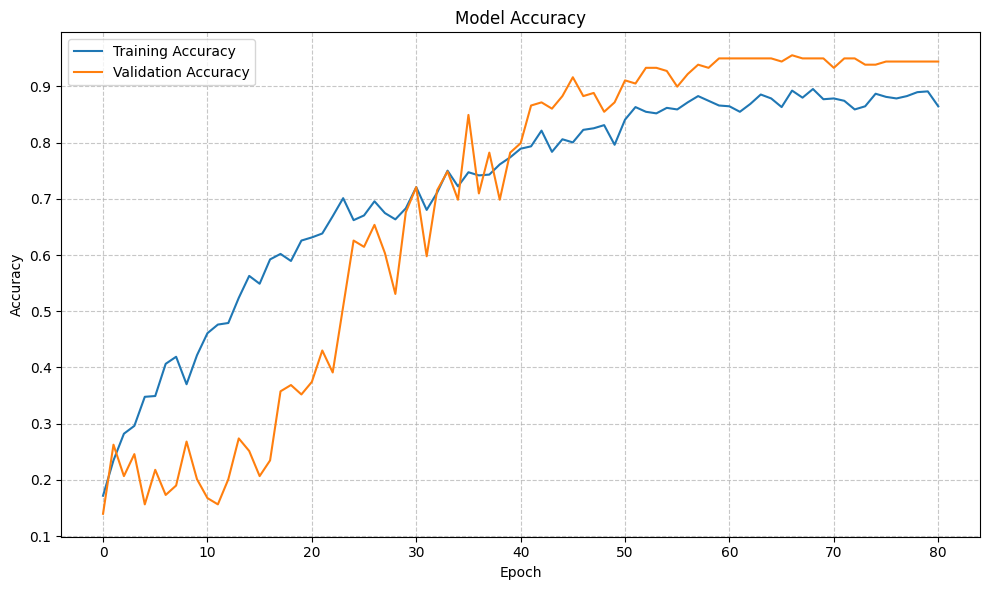

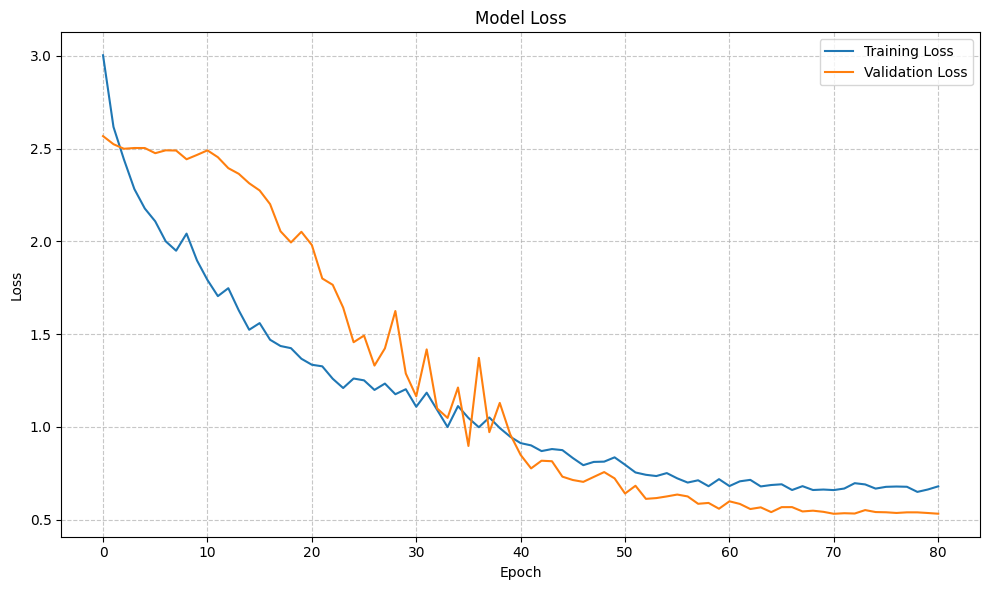


Best Model at Epoch 71:
Best Validation Accuracy: 0.9330
Best Validation Loss: 0.5309
Corresponding Training Accuracy: 0.8785
Corresponding Training Loss: 0.6587


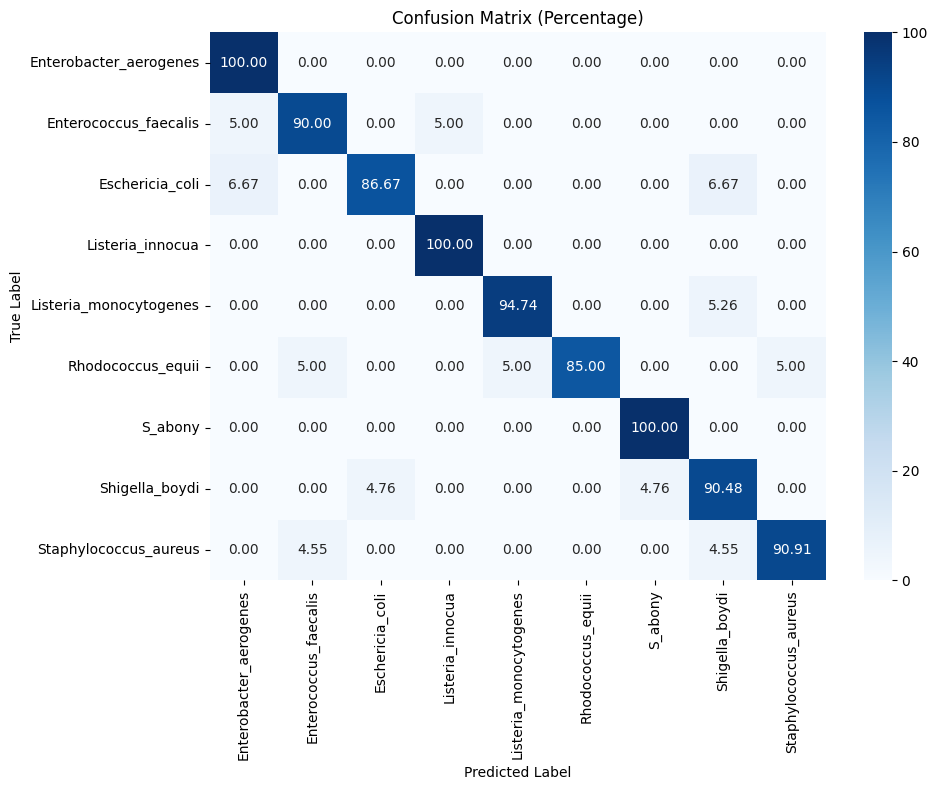


Overall Accuracy: 0.9330


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

def advanced_feature_selection(X, y, n_features=100):
    # Combine multiple feature selection techniques

    # Mutual Information Feature Selection
    selector_mi = SelectKBest(score_func=mutual_info_classif, k=n_features)
    X_mi = selector_mi.fit_transform(X, y)
    mi_features = selector_mi.get_support(indices=True)

    # PCA for dimensionality reduction
    pca = PCA(n_components=0.95)  # Retain 95% variance
    X_pca = pca.fit_transform(X)

    # Random Forest Feature Importance
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X, y)
    rf_importance = rf.feature_importances_
    top_rf_features = np.argsort(rf_importance)[-n_features:]

    # Combine feature sets
    combined_features = list(set(mi_features) | set(top_rf_features))

    return X[:, combined_features], combined_features

def create_hybrid_model(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,),
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def robust_training_pipeline(X, y):
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Performance tracking
    cv_scores = []
    fold_histories = []
    fold_results = []

    # Full results storage
    all_predictions = []
    all_true_labels = []

    # Create a label encoder for consistent label mapping
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    num_classes = len(np.unique(y_encoded))

    for fold, (train_index, val_index) in enumerate(skf.split(X, y_encoded), 1):
        print(f"\nFold {fold}")

        # Split data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y_encoded[train_index], y_encoded[val_index]

        # Feature Selection
        X_train_selected, selected_features = advanced_feature_selection(X_train, y_train)
        X_val_selected = X_val[:, selected_features]

        # Neural Network Model
        model = create_hybrid_model(
            input_shape=X_train_selected.shape[1],
            num_classes=num_classes
        )

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-5
        )

        # Training
        history = model.fit(
            X_train_selected, y_train,
            validation_data=(X_val_selected, y_val),
            epochs=200,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Store training history for this fold
        fold_histories.append({
            'fold': fold,
            'history': history.history
        })

        # Predictions
        y_pred = model.predict(X_val_selected)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Store results
        all_predictions.extend(y_pred_classes)
        all_true_labels.extend(y_val)

        # Store fold-specific results
        fold_results.append({
            'fold': fold,
            'true_labels': y_val,
            'predicted_labels': y_pred_classes,
            'selected_features': selected_features,
            'X_val_selected': X_val_selected,
            'model': model
        })

        # Evaluate this fold
        fold_report = classification_report(y_val, y_pred_classes)
        print(f"Fold {fold} Classification Report:")
        print(fold_report)

    # Final overall report
    print("\nOverall Cross-Validation Results:")
    print(classification_report(all_true_labels, all_predictions))

    return fold_histories, fold_results, le

def analyze_fifth_fold(fold_histories, fold_results, label_encoder=None):
    """Analyze the 5th fold results and plot training/validation metrics"""
    if len(fold_histories) < 5:
        print("Error: 5th fold data not available")
        return

    # Get the 5th fold history and results
    fifth_fold_history = fold_histories[4]  # 0-indexed, so 4 is the 5th fold
    fifth_fold_results = fold_results[4]
    history = fifth_fold_history['history']

    # Print metrics for the 5th fold
    print("\n5th Fold Training/Validation Metrics:")
    print(f"Final Training Accuracy: {history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"Final Training Loss: {history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")

    # Plot accuracy - separate plot
    plt.figure(figsize=(10, 6))
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot loss - separate plot
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Get epoch with best validation performance
    best_epoch = np.argmin(history['val_loss'])
    print(f"\nBest Model at Epoch {best_epoch+1}:")
    print(f"Best Validation Accuracy: {history['val_accuracy'][best_epoch]:.4f}")
    print(f"Best Validation Loss: {history['val_loss'][best_epoch]:.4f}")
    print(f"Corresponding Training Accuracy: {history['accuracy'][best_epoch]:.4f}")
    print(f"Corresponding Training Loss: {history['loss'][best_epoch]:.4f}")

    # Create and plot confusion matrix
    plot_confusion_matrix(
        fifth_fold_results['true_labels'],
        fifth_fold_results['predicted_labels'],
        label_encoder
    )
def plot_confusion_matrix(y_true, y_pred, label_encoder=None):
    """Create and visualize a normalized confusion matrix for model predictions"""
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize by row (true label count)
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

    # Get class names if label encoder is provided
    if label_encoder is not None:
        class_names = label_encoder.classes_
    else:
        class_names = [f"Class {i}" for i in range(len(np.unique(y_true)))]

    # Create figure - separate plot
    plt.figure(figsize=(10, 8))

    # Plot confusion matrix as percentages
    sns.heatmap(
        cm_percentage,
        annot=True,
        fmt=".2f",
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Calculate and display overall accuracy
    accuracy = np.trace(cm) / np.sum(cm)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

# def plot_confusion_matrix(y_true, y_pred, label_encoder=None):
#     """Create and visualize a confusion matrix for model predictions"""
#     # Compute confusion matrix
#     cm = confusion_matrix(y_true, y_pred)

#     # Get class names if label encoder is provided
#     if label_encoder is not None:
#         class_names = label_encoder.classes_
#     else:
#         class_names = [f"Class {i}" for i in range(len(np.unique(y_true)))]

#     # Create figure - separate plot
#     plt.figure(figsize=(10, 8))

#     # Plot confusion matrix
#     sns.heatmap(
#         cm,
#         annot=True,
#         fmt='d',
#         cmap='Blues',
#         xticklabels=class_names,
#         yticklabels=class_names
#     )

#     plt.title('Confusion Matrix')
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.tight_layout()
#     plt.show()

#     # Calculate and display metrics
#     print("\nConfusion Matrix Metrics:")
#     total = np.sum(cm)
#     accuracy = np.trace(cm) / total
#     print(f"Accuracy: {accuracy:.4f}")

#     if cm.shape[0] == 2:  # For binary classification
#         tn, fp, fn, tp = cm.ravel()
#         precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#         recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#         f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

#         print(f"Precision: {precision:.4f}")
#         print(f"Recall: {recall:.4f}")
#         print(f"F1 Score: {f1:.4f}")
#     else:  # For multiclass, print per-class metrics
#         print("\nPer-Class Metrics:")
#         for i in range(len(class_names)):
#             tp = cm[i, i]
#             fp = np.sum(cm[:, i]) - tp
#             fn = np.sum(cm[i, :]) - tp
#             tn = np.sum(cm) - tp - fp - fn

#             precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#             recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#             f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

#             print(f"Class {class_names[i]}:")
#             print(f"  Precision: {precision:.4f}")
#             print(f"  Recall: {recall:.4f}")
#             print(f"  F1 Score: {f1:.4f}")

# Example usage (replace with your actual data loading)
df = pd.read_csv('/content/drive/MyDrive/preprocessed_ds used.csv')
X = df.drop(['label', 'Class'], axis=1).values
y = df['label'].values
# --- Updated Code Snippet ---
fold_histories, fold_results, le = robust_training_pipeline(X, y)  # Store the returned values
analyze_fifth_fold(fold_histories, fold_results, le)             # Pass fold_results and le to the function

In [ ]:
def plot_confusion_matrix(y_true, y_pred, label_encoder=None):
    """Create and visualize a normalized confusion matrix for model predictions"""
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize by row (true label count)
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

    # Get class names if label encoder is provided
    if label_encoder is not None:
        class_names = label_encoder.classes_
    else:
        class_names = [f"Class {i}" for i in range(len(np.unique(y_true)))]

    # Create figure - separate plot
    plt.figure(figsize=(10, 8))

    # Plot confusion matrix as percentages
    sns.heatmap(
        cm_percentage,
        annot=True,
        fmt=".2f",
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Calculate and display overall accuracy
    accuracy = np.trace(cm) / np.sum(cm)
    print(f"\nOverall Accuracy: {accuracy:.4f}")


5th Fold Training/Validation Metrics:
Final Training Accuracy: 0.8645
Final Validation Accuracy: 0.9441
Final Training Loss: 0.6789
Final Validation Loss: 0.5313


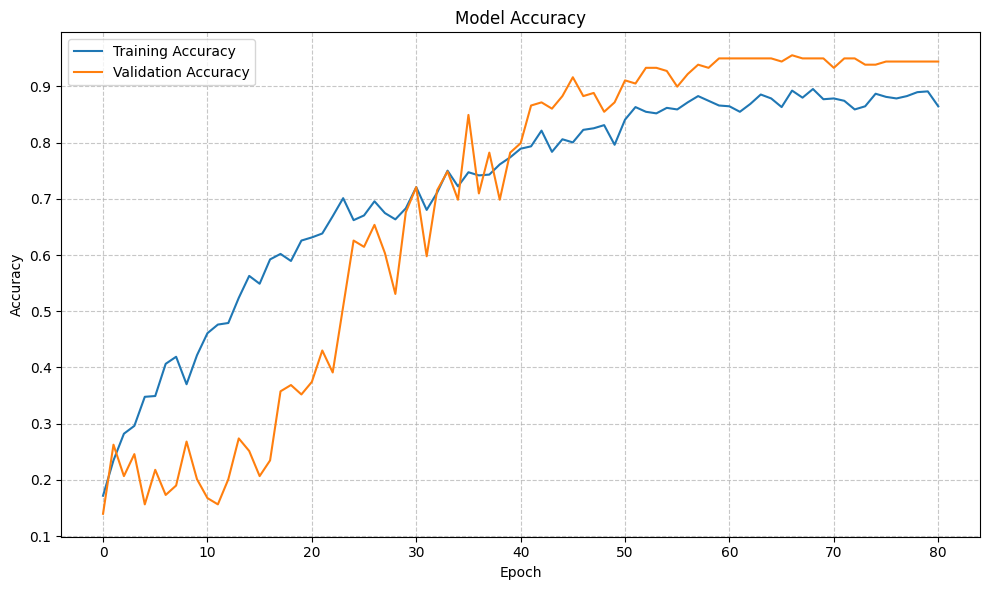

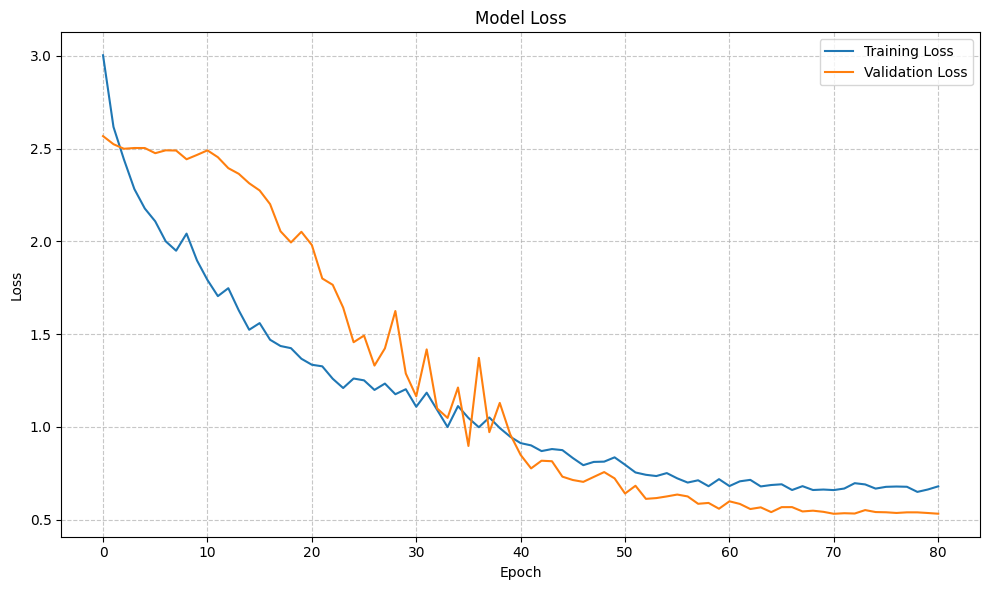


Best Model at Epoch 71:
Best Validation Accuracy: 0.9330
Best Validation Loss: 0.5309
Corresponding Training Accuracy: 0.8785
Corresponding Training Loss: 0.6587


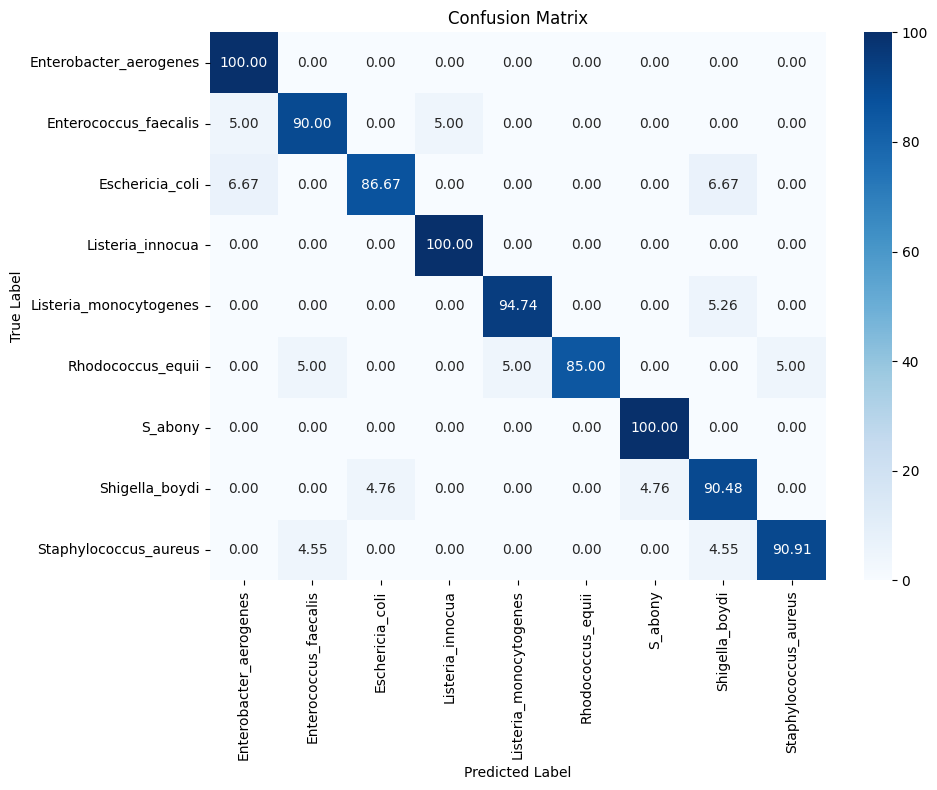


Overall Accuracy: 0.9330


In [ ]:
analyze_fifth_fold(fold_histories, fold_results, le)